### Update Nov. 10
#### EDA
- Representative features: **acousticness**, **danceability**, **energy**, **instrumentalness**, **speechiness**, **valence**, **track_number**, **duration_ms**, **loudness**.
- Not that representative features:**liveness**, **available_markets**, **key** and **tempo**.
- The rest features are hard to interpretate.

### 0: Import Library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve

### 1: Data Preprocessing

In [2]:
# read data
df = pd.read_csv('Dataset_model_building/songs.csv')
df.shape
print('Without any processing: {}'.format(df.shape))
print('Number of tracks in Top200: {}'.format((df.y==1).sum()))
print('Number of tracks in Non-Top200: {}'.format((df.y==0).sum()))

# remove duplicates
df = df.drop_duplicates(['track', 'artist'])
print('\nAfter removing duplicates: {}'.format(df.shape))
print('Number of tracks in Top200: {}'.format((df.y==1).sum()))
print('Number of tracks in Non-Top200: {}'.format((df.y==0).sum()))

# drop missing values
df = df.dropna()
print('\nAfter dropping missing values: {}'.format(df.shape))
print('Number of tracks in Top200: {}'.format((df.y==1).sum()))
print('Number of tracks in Non-Top200: {}'.format((df.y==0).sum()))

# deal with missing value of 'available_markets'
df['available_markets'] = df['available_markets'].replace(0, np.nan)
df['available_markets'] = df['available_markets'].replace(np.nan, df.available_markets.median())
print('\nAfter imputation: {}'.format(df.shape))
print('Number of tracks in Top200: {}'.format((df.y==1).sum()))
print('Number of tracks in Non-Top200: {}'.format((df.y==0).sum()))

Without any processing: (10809, 24)
Number of tracks in Top200: 7700
Number of tracks in Non-Top200: 3109

After removing duplicates: (3779, 24)
Number of tracks in Top200: 764
Number of tracks in Non-Top200: 3015

After dropping missing values: (3768, 24)
Number of tracks in Top200: 763
Number of tracks in Non-Top200: 3005

After imputation: (3768, 24)
Number of tracks in Top200: 763
Number of tracks in Non-Top200: 3005


### 2: Simple EDA
### 2.1 Numerical analysis

In [3]:
# have a quick look
df.describe()

,acousticness,available_markets,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,track_number,valence,y
count,3768.000000,3768.000000,3768.000000,3768.000000,3768.000000,3768.000000,3768.000000,3768.000000,3768.000000,3768.000000,3768.000000,3768.000000,3768.000000,3768.000000,3768.000000,3768.000000
mean,0.340561,43.618896,0.574322,216746.880308,0.578703,0.127604,5.209130,0.194356,-8.568219,0.642781,0.093299,118.235278,3.914013,7.246285,0.446243,0.202495
std,0.331892,26.359145,0.175540,72563.335624,0.244507,0.287171,3.543023,0.164359,5.035170,0.479244,0.117792,29.887655,0.413516,5.810096,0.242666,0.401912
min,0.000002,1.000000,0.061300,21148.000000,0.001260,0.000000,0.000000,0.021900,-43.162000,0.000000,0.023000,37.099000,1.000000,1.000000,0.000010,0.000000
25%,0.039800,3.000000,0.461000,182637.000000,0.410000,0.000000,2.000000,0.097800,-10.246750,0.000000,0.035500,94.958250,4.000000,3.000000,0.251000,0.000000
50%,0.215500,61.000000,0.592000,213139.500000,0.615000,0.000019,5.000000,0.125000,-7.132000,1.000000,0.048800,116.247500,4.000000,6.000000,0.426000,0.000000
75%,0.616000,62.000000,0.706000,246403.250000,0.772000,0.010625,8.000000,0.237000,-5.292000,1.000000,0.092925,138.039500,4.000000,10.000000,0.631000,0.000000
max,0.996000,62.000000,0.964000,819147.000000,0.996000,0.987000,11.000000,0.985000,-1.075000,1.000000,0.954000,220.251000,5.000000,50.000000,0.972000,1.000000


In [4]:
# correlation
df.corr()

,acousticness,available_markets,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,track_number,valence,y,featuring
acousticness,1.000000,0.044938,-0.229759,-0.187195,-0.729465,0.287436,-0.002117,-0.031915,-0.627845,0.067824,-0.005326,-0.164209,-0.168247,0.239997,-0.179385,-0.204295,-0.078503
available_markets,0.044938,1.000000,0.001448,-0.057501,-0.101515,0.045287,-0.034641,-0.004516,-0.116700,-0.044424,0.050923,0.013208,-0.034254,-0.049505,-0.015351,0.035451,0.062204
danceability,-0.229759,0.001448,1.000000,-0.112862,0.219107,-0.313056,0.002544,-0.133681,0.347102,-0.077276,0.200330,-0.008822,0.190519,-0.171395,0.498381,0.276735,0.129854
duration_ms,-0.187195,-0.057501,-0.112862,1.000000,0.195385,-0.082715,-0.013102,0.050903,0.229311,0.018895,-0.139622,0.039338,0.038610,-0.059643,-0.109136,0.007337,-0.007351
energy,-0.729465,-0.101515,0.219107,0.195385,1.000000,-0.318256,0.010290,0.134002,0.796348,-0.065011,-0.004552,0.202214,0.203833,-0.231864,0.393091,0.131516,0.066074
instrumentalness,0.287436,0.045287,-0.313056,-0.082715,-0.318256,1.000000,-0.008292,-0.064719,-0.537649,-0.047150,-0.129343,-0.090855,-0.151213,0.115426,-0.218063,-0.208381,-0.063172
key,-0.002117,-0.034641,0.002544,-0.013102,0.010290,-0.008292,1.000000,-0.006039,0.007609,-0.112020,0.043037,-0.019287,-0.020519,0.010367,0.028346,0.003437,0.013505
liveness,-0.031915,-0.004516,-0.133681,0.050903,0.134002,-0.064719,-0.006039,1.000000,0.035273,0.027832,0.085714,0.006842,0.038176,0.059846,0.058679,-0.060264,-0.022114
loudness,-0.627845,-0.116700,0.347102,0.229311,0.796348,-0.537649,0.007609,0.035273,1.000000,-0.023409,-0.073552,0.165974,0.228754,-0.269491,0.334079,0.210864,0.084738
mode,0.067824,-0.044424,-0.077276,0.018895,-0.065011,-0.047150,-0.112020,0.027832,-0.023409,1.000000,-0.065919,0.028568,-0.014385,0.041901,-0.027847,-0.047469,-0.040895


Looks like **energy**, **acousticness** and **loudness** have high relationship. Also, **danceability**, **instrumentalness** and **valence** have a little bit relationship.

In [5]:
# correlation > 0.2
df[['acousticness', 'danceability', 'energy', 'instrumentalness', 'loudness', 'track_number', 'y']].corr()

,acousticness,danceability,energy,instrumentalness,loudness,track_number,y
acousticness,1.000000,-0.229759,-0.729465,0.287436,-0.627845,0.239997,-0.204295
danceability,-0.229759,1.000000,0.219107,-0.313056,0.347102,-0.171395,0.276735
energy,-0.729465,0.219107,1.000000,-0.318256,0.796348,-0.231864,0.131516
instrumentalness,0.287436,-0.313056,-0.318256,1.000000,-0.537649,0.115426,-0.208381
loudness,-0.627845,0.347102,0.796348,-0.537649,1.000000,-0.269491,0.210864
track_number,0.239997,-0.171395,-0.231864,0.115426,-0.269491,1.000000,-0.253614
y,-0.204295,0.276735,0.131516,-0.208381,0.210864,-0.253614,1.000000


### 2.2 Graphical analysis

#### Pairplot
First look at the pairplot for the above features.

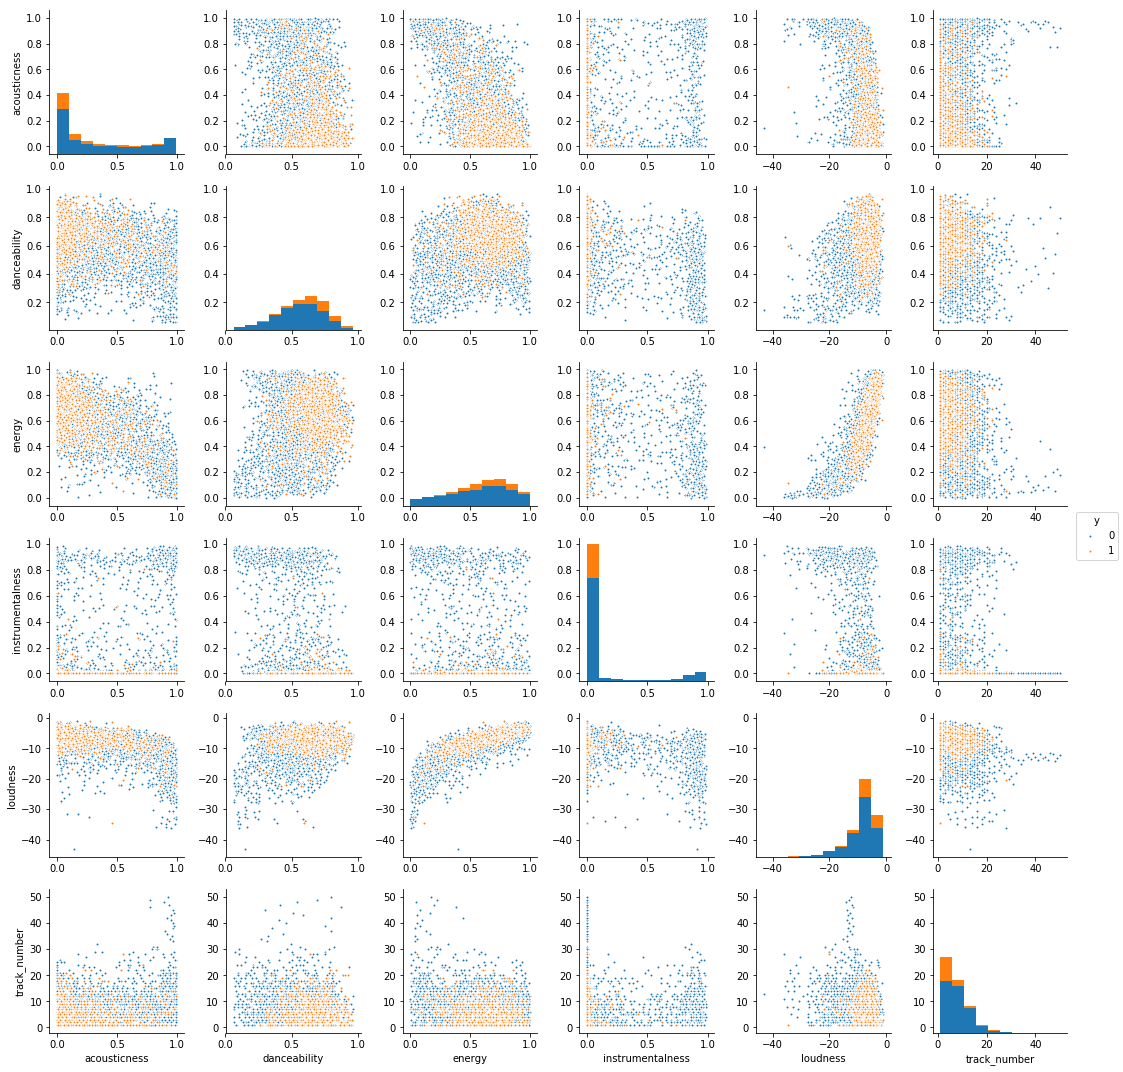

In [6]:
eda = df.copy()[['acousticness', 'danceability', 'energy', 'instrumentalness', 'loudness', 'track_number', 'y']]
col = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'loudness', 'track_number']
sns.pairplot(eda, hue='y', vars=col ,markers='.')
plt.show()

#### Boxplot

In [7]:
def mix_plot(df, figsize, lv=None, sp=None, pp=None, bp=None):
    """ function for stripplot easily"""
    
    # melt df
    eda = pd.melt(df, 'y', var_name='Measurement')
    
    # figure setup
    sns.set(style='whitegrid', font_scale=1.2)
    f, ax = plt.subplots(figsize=figsize)
    sns.despine(bottom=True, left=True)
    
    # lvplot
    if lv:
        sns.lvplot(x='value', y='Measurement', hue='y', data=eda)
        
    # boxplot
    if bp:
        sns.boxplot(x='value', y='Measurement', hue='y', data=eda, whis=np.inf, palette="vlag")
    
    # stripplot
    if sp:
        sns.stripplot(x='value', y='Measurement', hue='y', data=eda, dodge=.5, jitter=True, alpha=.1, zorder=1)

    # pointplot
    if pp:
        sns.pointplot(x='value', y='Measurement', hue='y', data=eda, dodge=.43, join=False, palette="dark", 
                      markers='x', scale=1.4, ci=None)

    # legend
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[-2:], labels[-2:], title='Top', handletextpad=0, columnspacing=1, frameon=True, loc="lower right")

    plt.show()

Make a plot for **acousticness**, **danceability**, **energy**, **instrumentalness**, **liveness**, **speechiness** and **valence** because these audio features have values ranged within [0, 1].

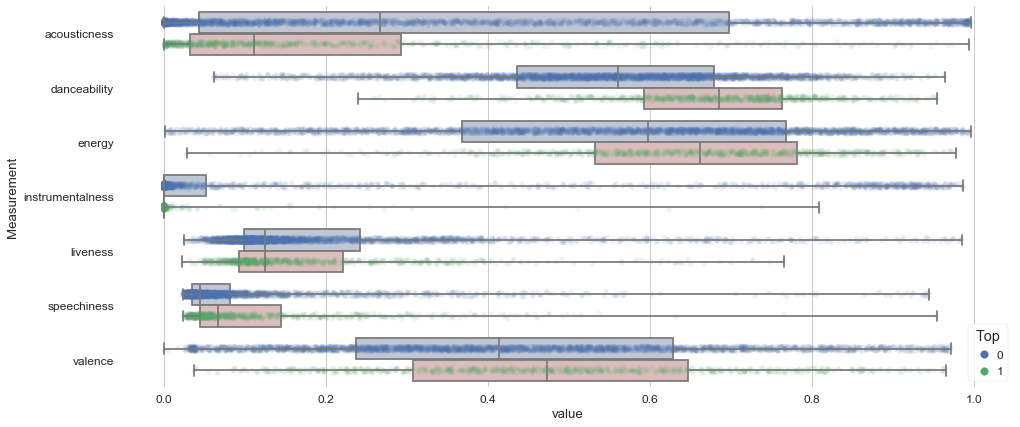

In [8]:
# 
coi = ['y', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'speechiness', 'valence']
eda = df.copy()[coi]
figsize = (16, 7)
mix_plot(eda, figsize, bp=1, sp=1, pp=0)

From the figure above, we can see that most of the audio features, except for **liveness**, have quite different distribution.

Next, let's have a look at **available_markets** and **track_number**.

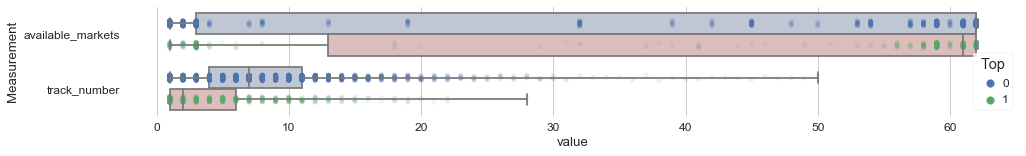

In [9]:
# available_markets and track_number
coi = ['y', 'available_markets', 'track_number']
eda = df.copy()[coi]
figsize = (16, 2)
mix_plot(eda, figsize, bp=1, sp=1, pp=0)

It seems that **track number** is more distinctable and thus could be a good feature for our binary classification problem. On the other hand, **available_markets** for both top and non-top songs have quite similar distrubtion.

Let's go to the next set of features, **duration_ms**, **key**, **loudness** and **tempo**.

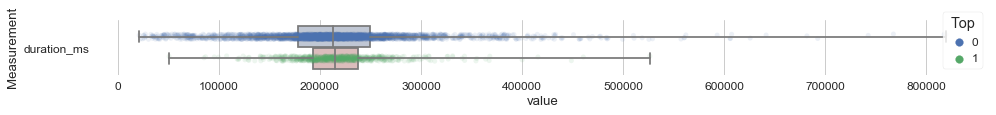

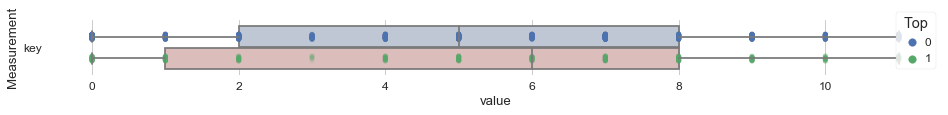

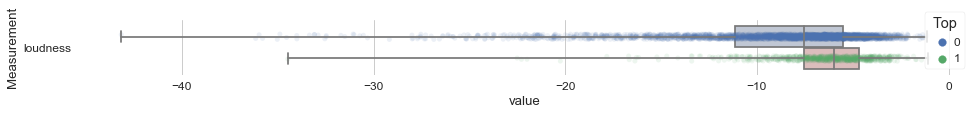

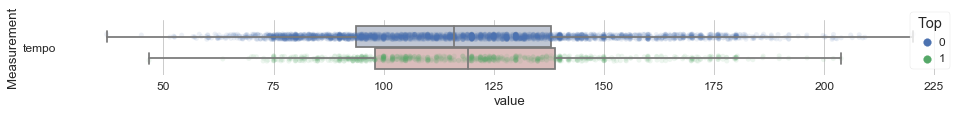

In [10]:
#  duration_ms
coi = ['y', 'duration_ms']
eda = df.copy()[coi]
figsize = (16, 1)
mix_plot(eda, figsize, bp=1, sp=1, pp=0)
# key
coi = ['y', 'key']
eda = df.copy()[coi]
figsize = (16, 1)
mix_plot(eda, figsize, bp=1, sp=1, pp=0)

# loudness
coi = ['y', 'loudness']
eda = df.copy()[coi]
figsize = (16, 1)
mix_plot(eda, figsize, bp=1, sp=1, pp=0)

# tempo
coi = ['y', 'tempo']
eda = df.copy()[coi]
figsize = (16, 1)
mix_plot(eda, figsize, bp=1, sp=1, pp=0)

Clearly, **loudness** is the most distinctive features among these four. In contrast, **duration_ms**, **key** and **tempo** are not very distinct between top and non-top songs. However, **duration_ms** for top songs is more dense than the non-top.

Finally, let's look at the rest features.

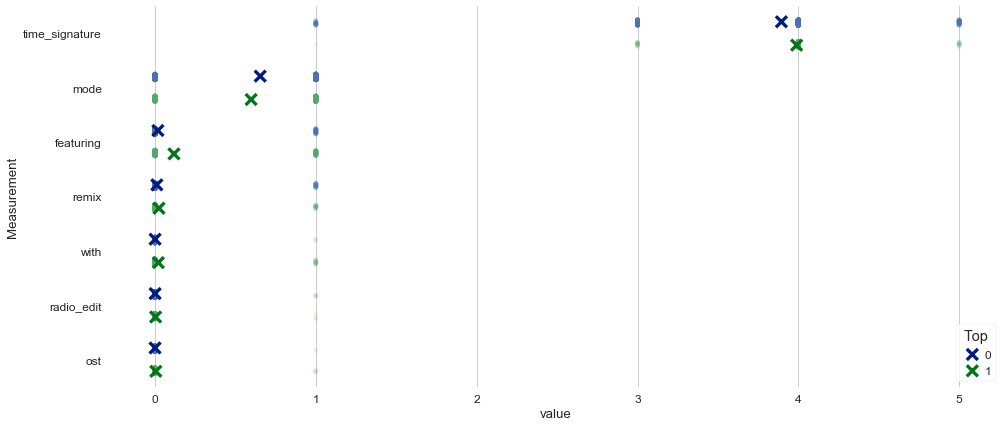

In [11]:
# time_signature, mode, featuring, remix, with, radio_edit, ost
coi = ['y', 'time_signature', 'mode', 'featuring', 'remix', 'with', 'radio_edit', 'ost',]
eda = df.copy()[coi]
figsize = (16, 7)
mix_plot(eda, figsize, lv=0, bp=0, sp=1, pp=1)

Due to the range of these features, we can't draw the boxplot. Therefore, we use **scatterplot with mean value**(labeled by *cross*) of to get a sense of data distrubtion. However, this is hard to intepretable. 